In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import pickle
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

DATA_PATH_IMDB = 'data/desafio_indicium_imdb.csv'

In [4]:
data_imdb = pd.read_csv(DATA_PATH_IMDB) 

#
<style>
    .custom-bg {
        background-color: #7d1a9b;
        font-family: Trebuchet MS;
        font-weight: bold;
        color: #eff7f6;
        font-size: 40px;
        text-align: center;
        border-radius: 100px;
        padding: 20px;
        display: block;
        width: 100%;
        margin: 0;
    }
</style>

<p class="custom-bg">PRÉ-PROCESSAMENTO</p>


In [5]:
data_imdb.head(3)

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"


Podemos veririficar que o nosso conjunto de dados temos cerca 427 valores ausentes, sendo eles nas colunas *Certificate* com 101 valores nulos, *Meta_score* com 157 valores ausentes e *Gross* com 169 valores ausentes.

*Certificate* representa a classificação etária

*Meta_score* representa a média ponderada de todas as críticas

*Gross* representa o faturamento do filme



Podemos imputar os valores faltantantes. Seguiremos a seguinte lógica:
1. A classificação etária faltante será substituida por classificação livre, ou seja, classificação para todas as idades;
2. A imputação dos valores faltantes do Meta_score será a média de todas as observações do nosso conjunto de dados;
3. O faturamento do filme será imputado sobre a média de todas as observações do nosso conjunto de dados, semelhante à imputação de valores do Meta_score.

In [6]:
data_imdb.isna().sum()

Unnamed: 0         0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

Antes da imputação, deveremos fazer um ajuste nos tipos de cada variável, como por exemplo *Gross* que no nosso conjunto de dados está identificado como object ao invés do tipo int.

In [7]:
data_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


Obtivemos um valor inconsistente no *Released_Year* com valor de "PG" a qual imputaremos via mediana que é uma medida mais interessante para o caso do ano. Nesse pré-processamos os valores faltantes foram substituidos pelo valor 0, e que imputaremos via média.

In [8]:
# Ajustando o tipo de Gross para o tipo int
data_imdb["Gross"] = data_imdb["Gross"].astype(str)
data_imdb["Gross"] = data_imdb["Gross"].str.replace(",", "")
data_imdb["Gross"] = data_imdb["Gross"].replace('nan', '0')
data_imdb["Gross"] = data_imdb["Gross"].astype(int)

# Ajustando o tipo de Runtime para o tipo inteiro
data_imdb["Runtime"] = data_imdb["Runtime"].astype(str)
data_imdb["Runtime"] = data_imdb["Runtime"].replace('nan', '0')
data_imdb["Runtime"] = data_imdb["Runtime"].str.split(" ").str[0]
data_imdb["Runtime"] = data_imdb["Runtime"].astype(int)

# Ajustando o tipo de Released_Year para o tipo int
data_imdb["Released_Year"] = data_imdb["Released_Year"].replace('PG', '0')
data_imdb["Released_Year"] = data_imdb["Released_Year"].astype(int)


Imputamos o valor de *Gross* via média.

In [9]:
# Calculando a média de Gross excluindo os valores 0
mean_gross = data_imdb[data_imdb["Gross"] > 0]["Gross"].mean()
# Imputando os valores 0 com a média de Gross
data_imdb["Gross"] = data_imdb["Gross"].replace(0, mean_gross)

Imputamos o valor de *Meta_score* via média.

In [10]:
# Calculando a média de Meta_score excluindo os valores NaN
mean_Meta_score = data_imdb[data_imdb["Meta_score"].notna()]["Meta_score"].mean()
# Substituindo os valores NaN de Meta_score pela média calculada
data_imdb["Meta_score"] = data_imdb["Meta_score"].fillna(mean_Meta_score)

Imputamos o valor anormal do *Released_Year* que anteriormente era "PG" pela mediana.

In [11]:
# Calculando a mediana de median_Released_Year
median_Released_Year = data_imdb[data_imdb["Released_Year"] > 0]["Released_Year"].median()
# Imputando o valor da mediana para o valor 0 que anteriormente era PG
data_imdb["Released_Year"] = data_imdb["Released_Year"].replace(0, median_Released_Year)

Imputamos os valores nulos de *Certificate* plea classificação livre "U" General Viewing for all ages 

In [12]:
# Substituindo os valores NaN de Certificate pela classificação livre "U" :General Viewing for all ages 
data_imdb["Certificate"] = data_imdb["Certificate"].fillna('U')

In [13]:
print('Valores faltantes')
data_imdb.isna().sum()


Valores faltantes


Unnamed: 0       0
Series_Title     0
Released_Year    0
Certificate      0
Runtime          0
Genre            0
IMDB_Rating      0
Overview         0
Meta_score       0
Director         0
Star1            0
Star2            0
Star3            0
Star4            0
No_of_Votes      0
Gross            0
dtype: int64

In [14]:
print('Tipo de dados de cada coluna')
data_imdb.dtypes

Tipo de dados de cada coluna


Unnamed: 0         int64
Series_Title      object
Released_Year      int32
Certificate       object
Runtime            int32
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross            float64
dtype: object

In [15]:
data_imdb.head(3)

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
1,2,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
2,3,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0


#
<style>
    .custom-bg {
        background-color: #7d1a9b;
        font-family: Trebuchet MS;
        font-weight: bold;
        color: #eff7f6;
        font-size: 40px;
        text-align: center;
        border-radius: 100px;
        padding: 20px;
        display: block;
        width: 100%;
        margin: 0;
    }
</style>

<p class="custom-bg">1. EDA</p>


In [16]:
print("Colunas do nosso conjunto de dados:")
display(data_imdb.columns)

Colunas do nosso conjunto de dados:


Index(['Unnamed: 0', 'Series_Title', 'Released_Year', 'Certificate', 'Runtime',
       'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1',
       'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')

<style>
    /* Estilo para a tabela */
    .custom-table-container {
        width: 100%;
        text-align: center; /* Centraliza o conteúdo */
        margin-bottom: 20px; /* Espaço abaixo da tabela */
    }

    .custom-table {
        font-family: Arial, sans-serif;
        border-collapse: collapse;
        width: 60%;
        margin: 0 auto; /* Centraliza a tabela */
    }

    /* Estilo para o cabeçalho da tabela */
    .custom-table th {
        background-color: #7d1a9b; /* Roxo escuro */
        color: #eff7f6; /* Branco */
        font-size: 16px;
        padding: 12px;
        text-align: left;
        border-bottom: 1px solid #ddd;
    }

    /* Estilo para as células da tabela */
    .custom-table td {
        padding: 12px;
        font-size: 14px;
        border-bottom: 1px solid #ddd;
    }

    /* Estilo para o título da tabela */
    .table-title {
        font-size: 24px;
        font-weight: bold;
        color: #7d1a9b; /* Roxo escuro */
        text-align: center;
        margin-bottom: 10px; /* Espaço abaixo do título */
    }

</style>

<div class="custom-table-container">
    <p class="table-title">Dicionário dos dados</p>
    <table class="custom-table">
        <tr>
            <th>Nome do campo</th>
            <th>Descrição</th>
        </tr>
        <tr>
            <td>Series_Title</td>
            <td>Nome do filme</td>
        </tr>
        <tr>
            <td>Released_Year</td>
            <td>Ano de lançamento</td>
        </tr>
        <tr>
            <td>Certificate</td>
            <td>Classificação etária</td>
        </tr>
        <tr>
            <td>Runtime</td>
            <td>Tempo de duração</td>
        </tr>
        <tr>
            <td>Genre</td>
            <td>Gênero</td>
        </tr>
        <tr>
            <td>IMDB_Rating</td>
            <td>Nota do IMDB</td>
        </tr>
        <tr>
            <td>Overview</td>
            <td>Overview do filme</td>
        </tr>
        <tr>
            <td>Meta_score</td>
            <td>Média ponderada de todas as críticas</td>
        </tr>
        <tr>
            <td>Director</td>
            <td>Diretor</td>
        </tr>
        <tr>
            <td>Star1</td>
            <td>Ator/atriz #1</td>
        </tr>
        <tr>
            <td>Star2</td>
            <td>Ator/atriz #2</td>
        </tr>
        <tr>
            <td>Star3</td>
            <td>Ator/atriz #3</td>
        </tr>
        <tr>
            <td>Star4</td>
            <td>Ator/atriz #4</td>
        </tr>
        <tr>
            <td>No_of_Votes</td>
            <td>Número de votos</td>
        </tr>
        <tr>
            <td>Gross</td>
            <td>Faturamento</td>
        </tr>
    </table>
</div>


In [17]:
top_movies_most_voted = data_imdb.sort_values(['No_of_Votes'], ascending = False)

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Podemos ver abaixo, com a análise gráfica que o filme bem mais votado chama-se The Dark Knight seguido de Inception e de Fight Club. No aparato geral.

In [18]:
# Função para formatar números em milhões
def millions_formatter(x, pos):
    return f'{x / 1e6:.0f}M'

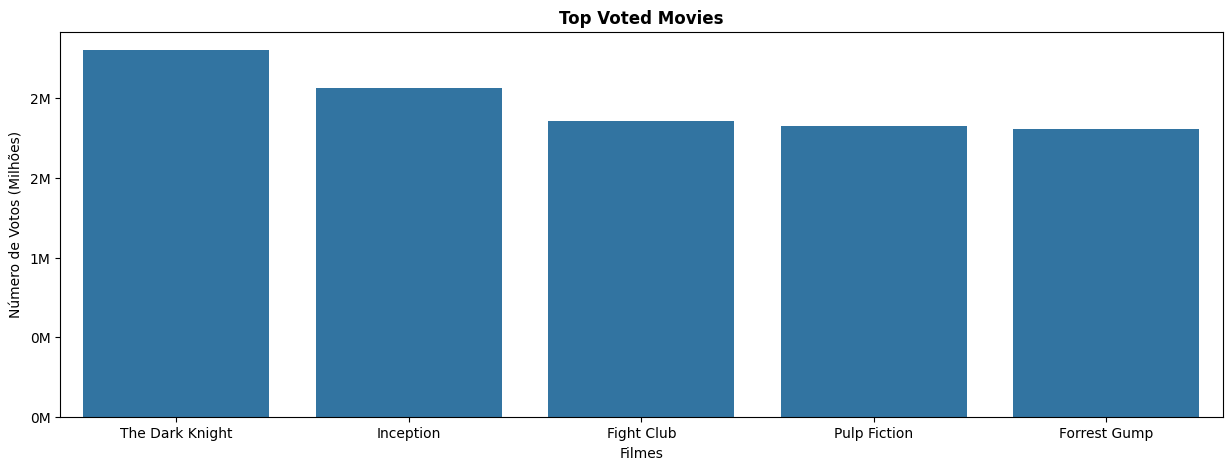

In [19]:
fig, axs = plt.subplots(figsize=(15, 5))
g = sns.barplot(x=top_movies_most_voted['Series_Title'][:5], y=top_movies_most_voted['No_of_Votes'][:5], ax=axs)
g.set_title("Top Voted Movies", weight="bold")

# Definindo rótulos dos eixos
axs.set_xlabel('Filmes')
axs.set_ylabel('Número de Votos (Milhões)')

# Aplicando formatação de milhões no eixo y
formatter = FuncFormatter(millions_formatter)
axs.yaxis.set_major_formatter(formatter)

plt.show()

In [20]:
data_imdb['Certificate'].unique()

array(['A', 'UA', 'U', 'PG-13', 'R', 'PG', 'G', 'Passed', 'TV-14', '16',
       'TV-MA', 'Unrated', 'GP', 'Approved', 'TV-PG', 'U/A'], dtype=object)

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #FF0000; text-align: left; "><b>Observações:</b></h1>

* U (Universal): Indicado para todos os públicos.
* A (Adult): Recomendado para adultos ou adolescentes acompanhados.
* UA (Universal Adult): Recomendado para todas as idades, mas com a supervisão de adultos.
* R (Restricted): Restrito; pode ser inadequado para menores de 18 anos.
* PG-13 (Parental Guidance): Pode não ser adequado para menores de 13 anos; recomenda-se orientação dos pais.
* PG (Parental Guidance Suggested): Pode não ser adequado para crianças pequenas; recomenda-se orientação dos pais.
* Passed: Indica que o filme passou na revisão do código de produção ou de censura.

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Graficamente, os dados sobre os filmes indicam e também é natural de obter mais filmes com classificação livre para todos os públicos;
* Podemos também observar que filmes adultos são populares, sendo o segundo segmento com mais relevância;
* Observa-se também que há conteúdos que diferem da indicação recomendada para todos os públicos, mas com supervisão dos pais, indicando assim algum conteúdo sensível incorporado no filme por exemplo.

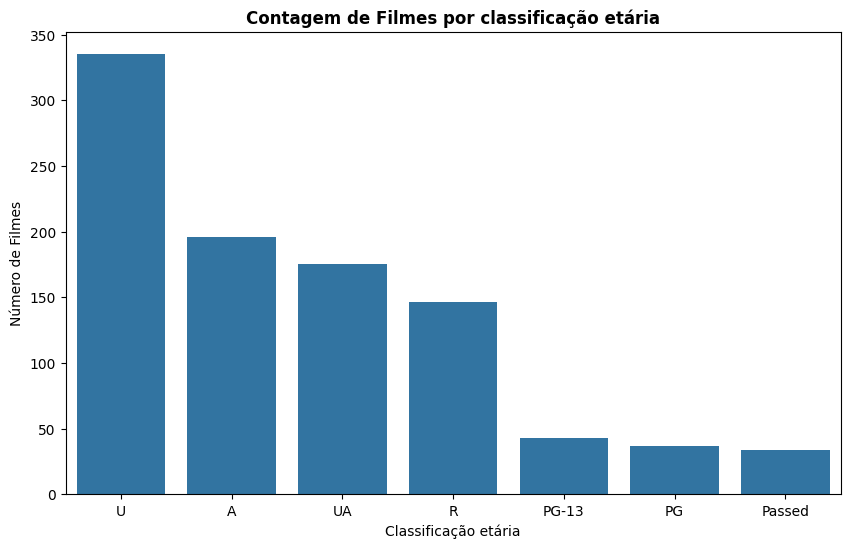

In [21]:
# Criação da figura e dos eixos
fig, axs = plt.subplots(figsize=(10, 6))

# Contagem de ocorrências de cada categoria de certificado
certificate_counts = data_imdb['Certificate'].value_counts()

# Criando o gráfico de barras
g = sns.barplot(x=certificate_counts.index[:7], y=certificate_counts.values[:7], ax=axs)

# Título do gráfico
g.set_title("Contagem de Filmes por classificação etária", weight="bold")

# Definindo rótulos dos eixos
axs.set_xlabel('Classificação etária')
axs.set_ylabel('Número de Filmes')

# Exibindo o gráfico
plt.show()

In [22]:
# Função para obter os top 5 filmes mais bem votados de uma categoria específica, ordenados por votos
def get_top_movies_by_certificate(data, certificate):
    top_movies = data[data['Certificate'] == certificate].nlargest(5, 'No_of_Votes')
    return top_movies

# Função para plotar os top 5 filmes mais bem votados por certificação
def plot_top_movies_by_certificate(data, certificate, millions=False):
    # Obtendo os top 5 filmes mais bem votados para a classificação especificada, ordenados por votos
    top_movies = get_top_movies_by_certificate(data, certificate)
    top_movies = top_movies.sort_values(by='No_of_Votes', ascending=False)  # Ordenando por número de votos
    
    # Configuração da figura e do subplot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plotagem do gráfico de barras horizontal
    g = sns.barplot(x='No_of_Votes', y='Series_Title', data=top_movies, ax=ax)
    
    # Configuração do título do gráfico
    ax.set_title(f"Top 5 Filmes mais bem votados - Classificação: {certificate}")
    
    # Configuração dos rótulos dos eixos
    ax.set_xlabel('Número de Votos')
    ax.set_ylabel('Filme')
    
    # Exibindo os valores no eixo x como milhões, se especificado
    if millions:
        ax.set_xticklabels([f'{int(x/1000000)}M' for x in ax.get_xticks()])
    
    # Exibindo o gráfico
    plt.tight_layout()
    plt.show()

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Observamos que para a classificação livre temos que o filme The Lord of the Rings foi o melhor avalidado seguido do seu filme sucessor (continuação) e de The Prestige. Vemos a consistência dos dados.

C:\Users\allan\AppData\Local\Temp\ipykernel_8760\695597209.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x/1000000)}M' for x in ax.get_xticks()])


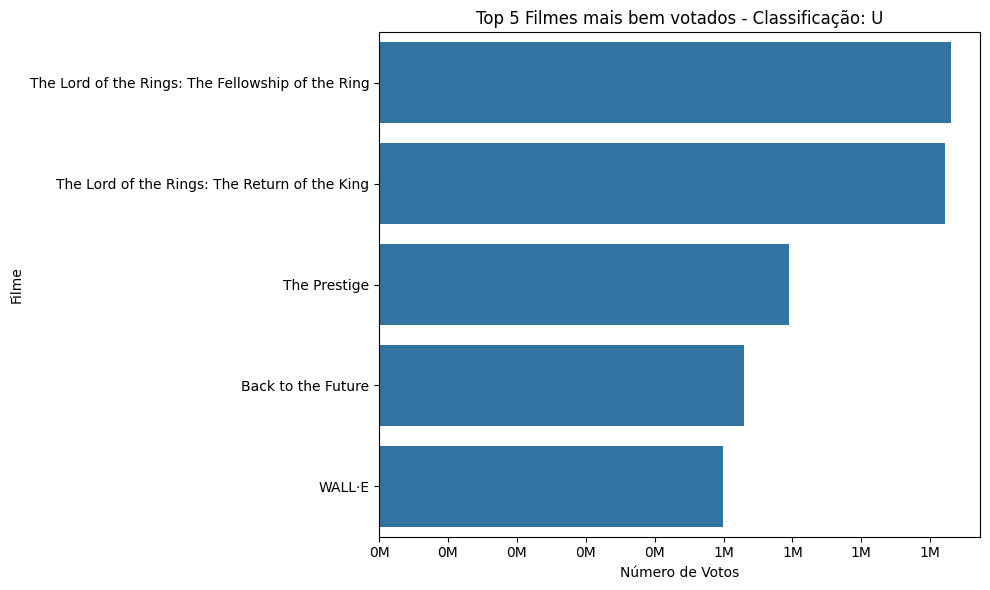

In [23]:
plot_top_movies_by_certificate(data_imdb, 'U', millions=True)

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Ao analisar a classificação adulta podemos ver os filmes melhores avaliados, que são os filmes Fight Club com a melhor avaliação seguido de Pulp Fiction e The Matirx.

C:\Users\allan\AppData\Local\Temp\ipykernel_8760\695597209.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x/1000000)}M' for x in ax.get_xticks()])


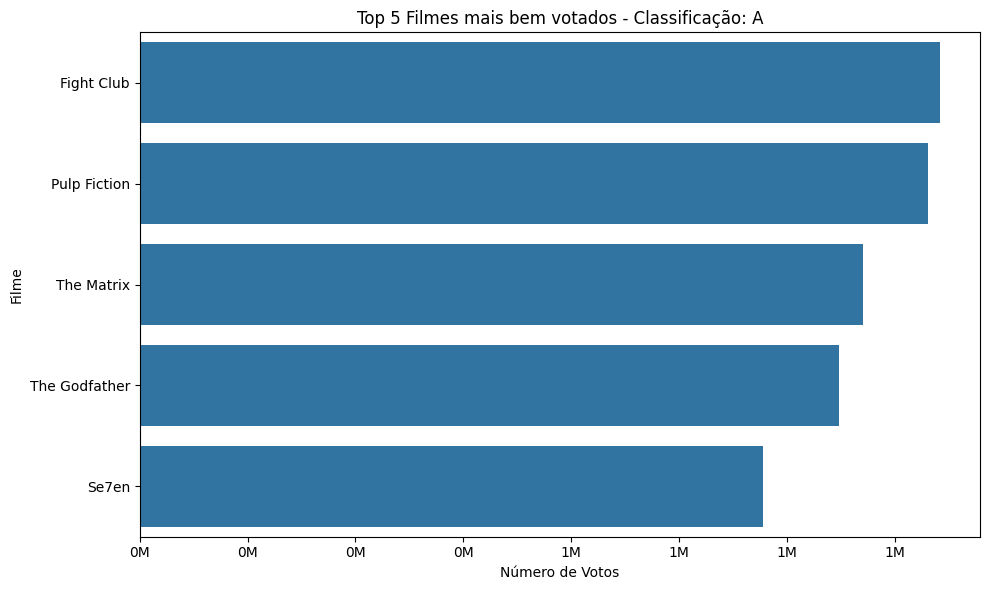

In [24]:
plot_top_movies_by_certificate(data_imdb, 'A', millions=True)

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Ao analisar a classificação adulta podemos ver os filmes melhores avaliados, que são os filmes Fight Club com a melhor avaliação seguido de Pulp Fiction e The Matrix.

C:\Users\allan\AppData\Local\Temp\ipykernel_8760\695597209.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x/1000000)}M' for x in ax.get_xticks()])


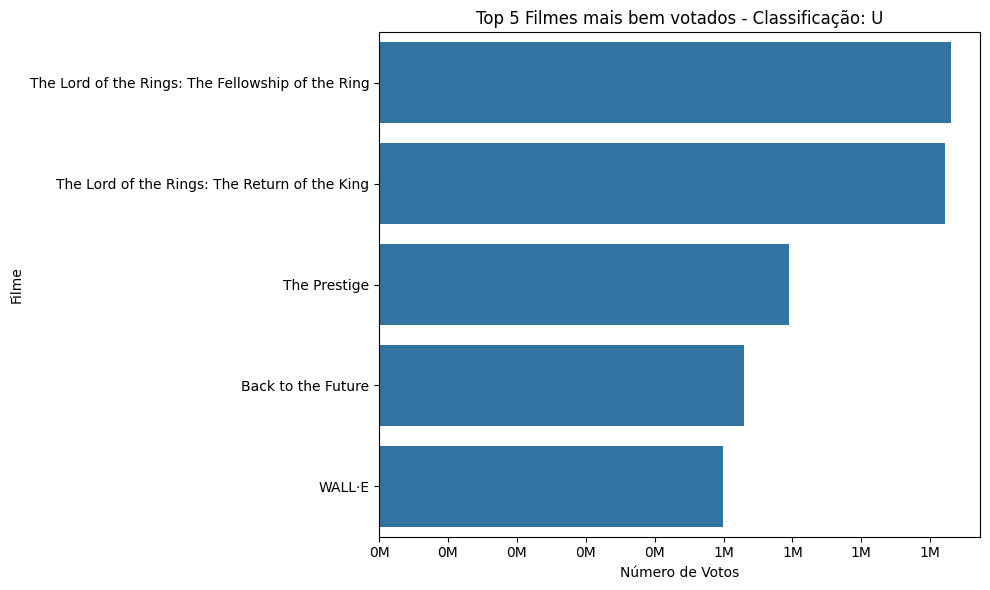

In [25]:
plot_top_movies_by_certificate(data_imdb, 'U', millions=True)

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Insights:</b></h1>

<p>Nesta análise podemos observar o faturamento por diretor, ou seja, o montante de faturamento de todos os filmes de algum diretor. Observa-se que o diretor de destaque é o <a href="https://pt.wikipedia.org/wiki/Steven_Spielberg" style="color: #368f8b; text-decoration: none;">Steven Spielberg</a>, seguido de <a href="https://pt.wikipedia.org/wiki/Irm%C3%A3os_Russo" style="color: #368f8b; text-decoration: none;">Anthony Russo</a> e de <a href="https://pt.wikipedia.org/wiki/Christopher_Nolan" style="color: #368f8b; text-decoration: none;">Christopher Nolan</a>.</p>


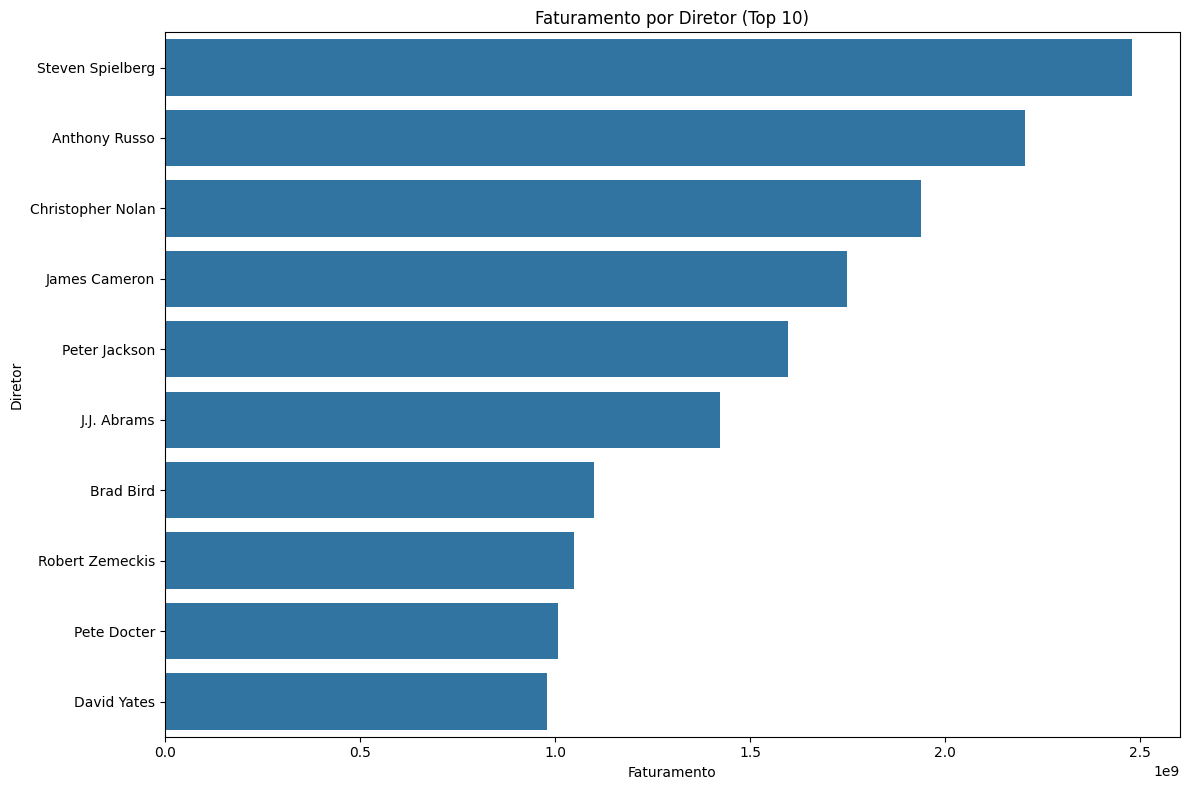

In [26]:
# Agrupando por diretor e somando o faturamento
director_gross = data_imdb.groupby('Director')['Gross'].sum().reset_index()

# Ordenando por faturamento decrescente
director_gross = director_gross.sort_values(by='Gross', ascending=False).head(10)

# Configurando a figura e os eixos
plt.figure(figsize=(12, 8))
sns.barplot(x='Gross', y='Director', data=director_gross)

# Configurando o título e os rótulos dos eixos
plt.title('Faturamento por Diretor (Top 10)')
plt.xlabel('Faturamento')
plt.ylabel('Diretor')

# Exibindo o gráfico
plt.tight_layout()
plt.show()

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Insights:</b></h1>

* <p>Nesta análise podemos observar o número de votos por diretor. Observa-se que o diretor que tem mais votos em seus filmes é o <a href="https://pt.wikipedia.org/wiki/Christopher_Nolan" style="color: #368f8b; text-decoration: none;">Christopher Nolan</a> seguido de Quentian Tarantino e <a href="https://pt.wikipedia.org/wiki/Steven_Spielberg" style="color: #368f8b; text-decoration: none;">Steven Spielberg</a>.</p>

* Observa-se que os dois mais bem faturados aparecem também na lista de mais bem votados, ou seja, os diretores que t~em seus filmes bem mais votados.


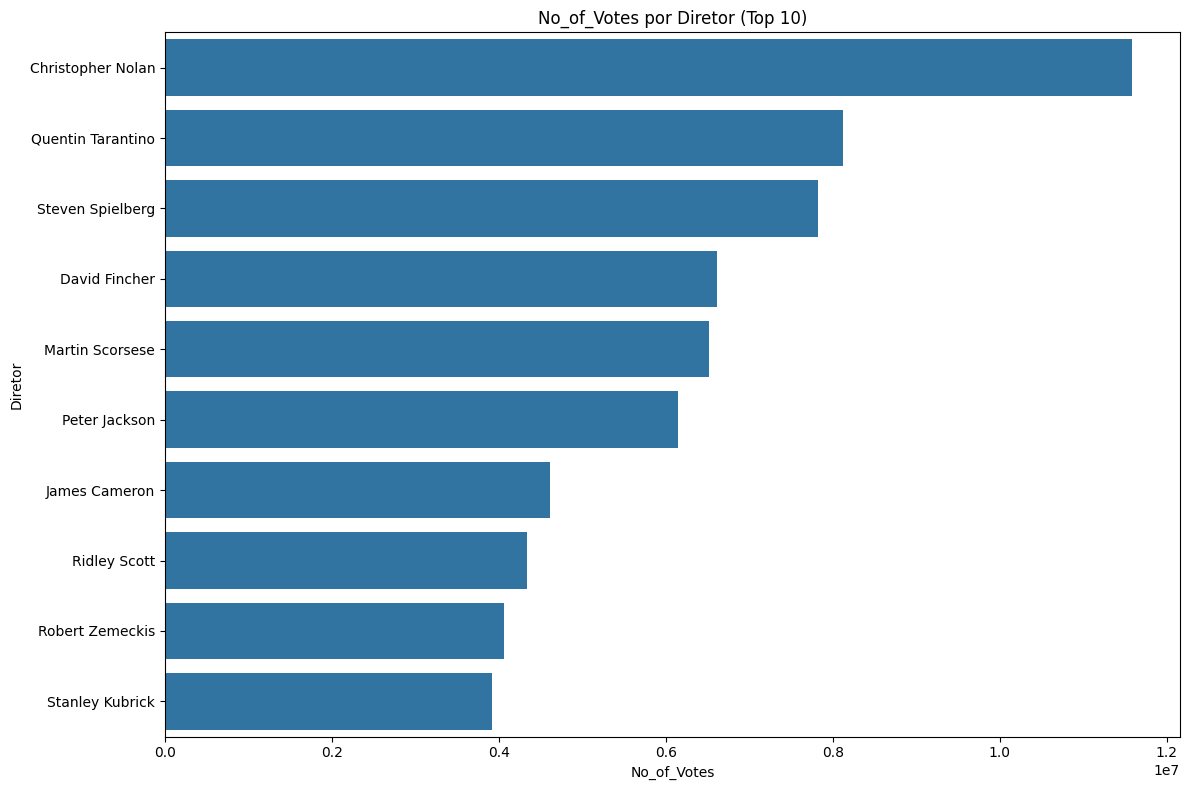

In [27]:
# Agrupando por diretor e somando o No_of_Votes
director_No_of_Votes = data_imdb.groupby('Director')['No_of_Votes'].sum().reset_index()

# Ordenando por faturamento decrescente
director_No_of_Votes = director_No_of_Votes.sort_values(by='No_of_Votes', ascending=False).head(10)

# Configurando a figura e os eixos
plt.figure(figsize=(12, 8))
sns.barplot(x='No_of_Votes', y='Director', data=director_No_of_Votes)

# Configurando o título e os rótulos dos eixos
plt.title('No_of_Votes por Diretor (Top 10)')
plt.xlabel('No_of_Votes')
plt.ylabel('Diretor')

# Exibindo o gráfico
plt.tight_layout()
plt.show()

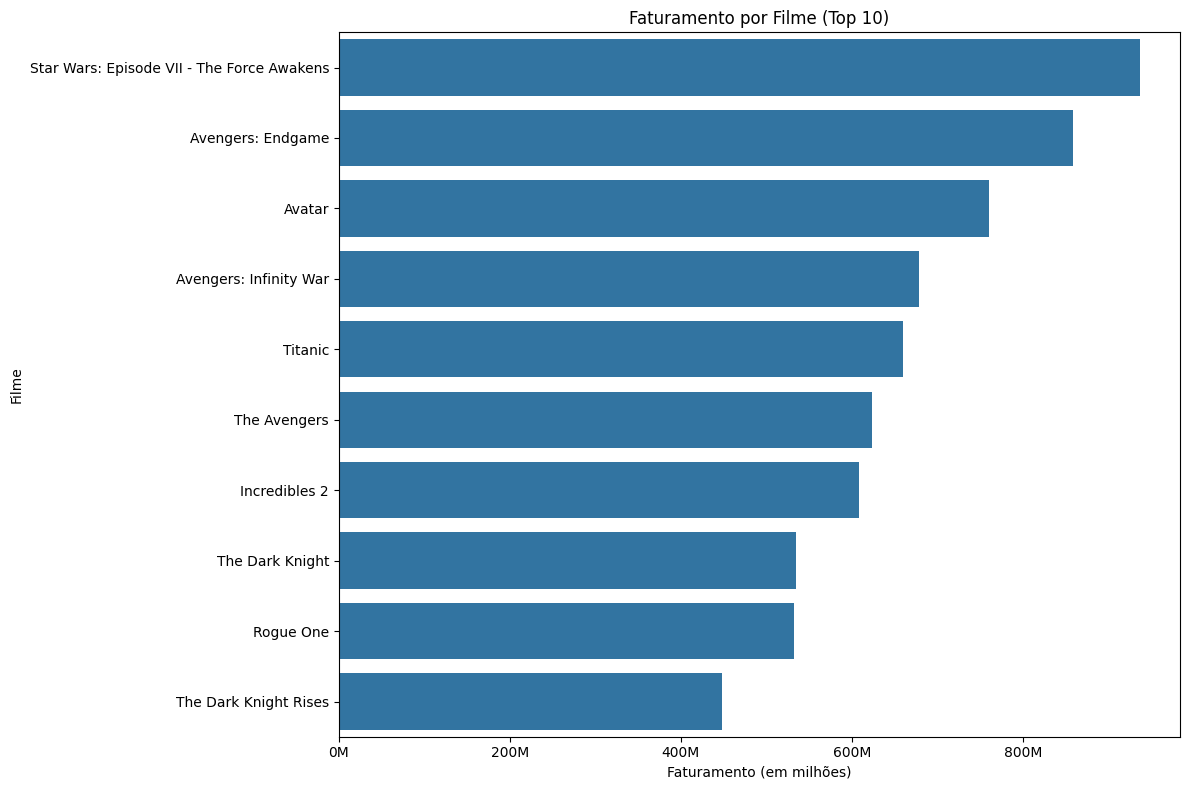

In [28]:
# Agrupando por filme e somando o faturamento
Series_Title_gross = data_imdb.groupby('Series_Title')['Gross'].sum().reset_index()

# Ordenando por faturamento decrescente e pegando os top 10
Series_Title_gross = Series_Title_gross.sort_values(by='Gross', ascending=False).head(10)

# Convertendo o faturamento para milhões
Series_Title_gross['Gross_Millions'] = Series_Title_gross['Gross'] / 1e6  # Convertendo para milhões

# Configurando a figura e os eixos
plt.figure(figsize=(12, 8))
sns.barplot(x='Gross_Millions', y='Series_Title', data=Series_Title_gross)

# Configurando o título e os rótulos dos eixos
plt.title('Faturamento por Filme (Top 10)')
plt.xlabel('Faturamento (em milhões)')
plt.ylabel('Filme')

# Formatando os rótulos do eixo x para milhões
formatter = FuncFormatter(lambda x, _: f'{x:.0f}M')
plt.gca().xaxis.set_major_formatter(formatter)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

In [29]:
director_Series_Title = data_imdb.groupby('Director')['Series_Title'].apply(list).reset_index()
director_Series_Title = director_Series_Title.explode('Series_Title')


In [30]:
director_Series_Title[director_Series_Title['Director'] == 'Steven Spielberg']


,Director,Series_Title
470,Steven Spielberg,Schindler's List
470,Steven Spielberg,Saving Private Ryan
470,Steven Spielberg,Raiders of the Lost Ark
470,Steven Spielberg,Indiana Jones and the Last Crusade
470,Steven Spielberg,Catch Me If You Can
470,Steven Spielberg,Jurassic Park
470,Steven Spielberg,Jaws
470,Steven Spielberg,The Color Purple
470,Steven Spielberg,E.T. the Extra-Terrestrial
470,Steven Spielberg,Empire of the Sun


<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Insights:</b></h1>

* Pela matriz de correlação podemos observar que a medida que cresce o número de votos a faturamento do filme cresce, ou seja, a quantidade de votos e/ou avaliações está diretamente ligado ao crescimento do faturamento;
* Observa-se também que a medida que anota do IMDB cresce aquantidade de votos também cresce implicando que o faturamento irá crescer também.



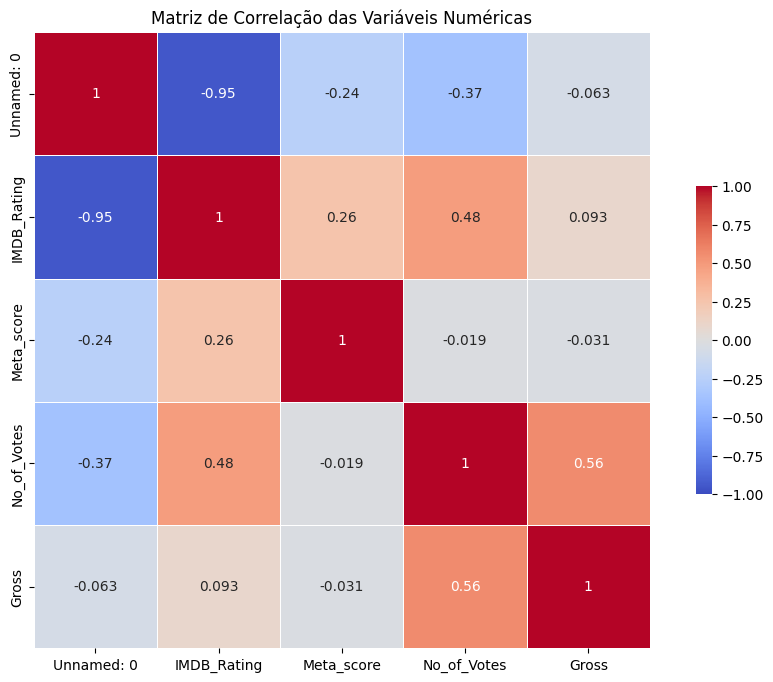

In [31]:
# Selecionando apenas as variáveis numéricas
numeric_columns = data_imdb.select_dtypes(include=['int64', 'float64'])

# Calculando a matriz de correlação
correlation_matrix = numeric_columns.corr()

# Configurando o tamanho da figura
plt.figure(figsize=(12, 8))

# Plotando a matriz de correlação usando seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Adicionando título
plt.title('Matriz de Correlação das Variáveis Numéricas')

# Exibindo o gráfico
plt.show()

In [32]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Qual filme você recomendaria para uma pessoa que você não conhece?</b></h1>

* As palavras "life", "one", "find", "love" aparecem bastante.



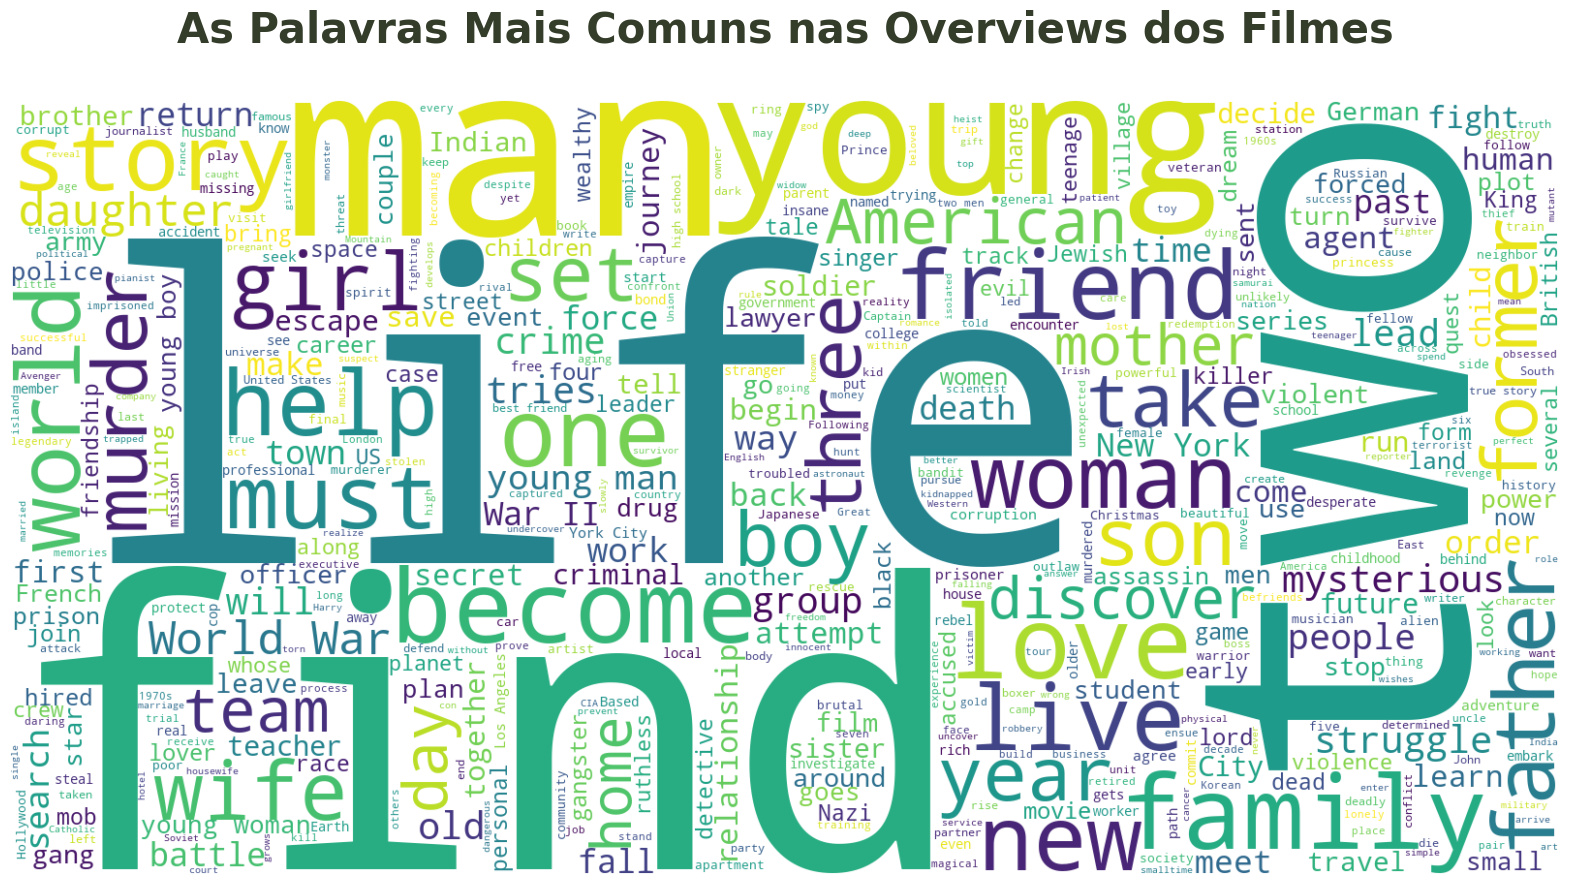

In [33]:
from wordcloud import WordCloud
import string

# Concatenando todas as overviews em uma única string
text = ' '.join(data_imdb['Overview'].fillna('').apply(lambda x: x.translate(str.maketrans('', '', string.punctuation))))

# Criando a nuvem de palavras
plt.figure(figsize=(20, 20))
plt.title('As Palavras Mais Comuns nas Overviews dos Filmes\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10, height=800, width=1600, background_color="white").generate(text)

# Exibindo a nuvem de palavras
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Removendo os eixos
plt.show()

#
<style>
    .custom-bg {
        background-color: #7d1a9b;
        font-family: Trebuchet MS;
        font-weight: bold;
        color: #eff7f6;
        font-size: 40px;
        text-align: center;
        border-radius: 100px;
        padding: 20px;
        display: block;
        width: 100%;
        margin: 0;
    }
</style>

<p class="custom-bg">2. PERGUNTAS</p>


<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Qual filme você recomendaria para uma pessoa que você não conhece?</b></h1>

* Recomendaria aquele filme com melhor avaliação, ou seja, recomendaria o filme The Dark Knight 



<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 
</b></h1>

* Principalmente a quantidade de votos do filme, mas também o diretor que está dirigindo o filme têm grande influência. 



<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

</b></h1>

* A "Overview" oferece uma visão geral do tema principal do filme. Isso pode ajudar a identificar se é um drama, ação, comédia, suspense, entre outros;
* Algumas sinopses podem indicar claramente para qual público o filme é direcionado. Por exemplo, se a sinopse descreve temas infantis, familiares, ou se aborda questões mais maduras e complexas;
* É possível utilizando métodos especificos determinar o gênero do filme.



#
<style>
    .custom-bg {
        background-color: #7d1a9b;
        font-family: Trebuchet MS;
        font-weight: bold;
        color: #eff7f6;
        font-size: 40px;
        text-align: center;
        border-radius: 100px;
        padding: 20px;
        display: block;
        width: 100%;
        margin: 0;
    }
</style>

<p class="custom-bg">3. PREVISÃO DA NOTA IMDB</p>


A nota do IMBD é uma variável contínua, então para a sua previsão poderiamos usar métodos de regressão para determina-lo, pois não entra do caso de classificação.

Nosso problema para esse caso é de regressão: Determinar a note IMDB para os filmes.


O conjunto de dados já passou da etapa de pré-processamento, faremos a etapa de identificação de colunas para ser aplicado a normalização dos dados. Para as variáveis qualitativas, podemos usar o OrdinalEncoder para codificar variáveis categóricas como números inteiros.

Para as variáveis numéricas vamos aplicar o StandardScaler.

In [34]:
features = ['Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes', 'Gross','Certificate', 'Director', 'Star1', 'Star2', 'Star3', 'Star4']
target = 'IMDB_Rating'

X = data_imdb[features]
y = data_imdb[target]

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Configurando o pré-processamento
numeric_features = ['Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes', 'Gross']
categorical_features = ['Certificate', 'Director', 'Star1', 'Star2', 'Star3', 'Star4']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Criando o pipeline completo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Released_Year', 'Runtime',
                                                   'Meta_score', 'No_of_Votes',
                                                   'Gross']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Certificate', 'Director',
                                                   'Star1', 'Star2', 'Star3',
                                                   'Star4'])]))])

In [36]:
# Aplicando o pipeline aos dados de treino e teste
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)



## <h1 style="font-family: Trebuchet MS; font-size: 25px; color: #7d1a9b; text-align: left; "><b>● XGBRegressor</b></h1>

In [37]:
# Criando o modelo XGBoost para regressão
xgb_model = XGBRegressor(random_state=42)

# Treinando o modelo
xgb_model.fit(X_train_preprocessed, y_train)

# Fazendo previsões
y_pred_xg = xgb_model.predict(X_test_preprocessed)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred_xg)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.04314232372636139



## <h1 style="font-family: Trebuchet MS; font-size: 25px; color: #7d1a9b; text-align: left; "><b>● REGRESSÃO LINEAR</b></h1>

In [38]:
rl_model = LinearRegression()

# Treinar o modelo com os dados de treino
rl_model.fit(X_train_preprocessed, y_train)

# Fazendo previsões
y_pred_rl = rl_model.predict(X_test_preprocessed)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred_rl)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.05049554048059976


## <h1 style="font-family: Trebuchet MS; font-size: 25px; color: #7d1a9b; text-align: left; "><b>● SVR</b></h1>

In [39]:
svr_model = SVR(kernel='rbf')

# Treinar o modelo com os dados de treino
svr_model.fit(X_train_preprocessed, y_train)

# Fazendo previsões
y_pred_svr = svr_model.predict(X_test_preprocessed)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred_svr)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.07523768004493607


## <h1 style="font-family: Trebuchet MS; font-size: 25px; color: #7d1a9b; text-align: left; "><b>● Decision Tree Regressor</b></h1>

In [40]:
dt_model = DecisionTreeRegressor(random_state=42)

# Treinar o modelo com os dados de treino
dt_model.fit(X_train_preprocessed, y_train)

# Fazendo previsões
y_pred_dt = dt_model.predict(X_test_preprocessed)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred_dt)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.07115000000000003


#
<style>
    .custom-bg {
        background-color: #7d1a9b;
        font-family: Trebuchet MS;
        font-weight: bold;
        color: #eff7f6;
        font-size: 40px;
        text-align: center;
        border-radius: 100px;
        padding: 20px;
        display: block;
        width: 100%;
        margin: 0;
    }
</style>

<p class="custom-bg">PERGUNTAS DE PREVISÃO DA NOTA IMDB</p>


Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?


<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Quais variáveis e/ou suas transformações você utilizou e por quê?</b></h1>

* Variáveis usadas: Released_Year, Runtime, Meta_score, No_of_Votes, Gross, Certificate, Director, Star1, Star2, Star3, Star4
* A motivação veio a partir da análise descritiva dos dados e pela importância dessas variáveis com as suas informações valiosas.


<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Qual tipo de problema estamos resolvendo (regressão, classificação)?</b></h1>

* A nota do IMBD é uma variável contínua, então para a sua previsão poderiamos usar métodos de regressão para determina-lo, pois não entra do caso de classificação.

* Nosso problema para esse caso é de regressão: Determinar a note IMDB para os filmes.


<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Qual modelo melhor se aproxima dos dados e quais seus prós e contras?</b></h1>

* O modelo que obteve uma melhor perfomace foi o XGBRegressor muito utilizado em competições e projetos;

* Prós do XGBRegressor: Alta Performance, Regularização Integrada, Flexibilidade e Larga Aceitação na Comunidade;

* Contras do XGBRegressor: Afinamento de Hiperparâmetros e Sensível a Overfitting.


<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Qual medida de performance do modelo foi escolhida e por quê?
</b></h1>

* Foi utilizado a medida MSE, pois podemos ver uma médida do desvio do nosso valor previsto com o valor real. Quanto menor então quer dizer que o nosso modelo tem uma precisão melhor.


#
<style>
    .custom-bg {
        background-color: #7d1a9b;
        font-family: Trebuchet MS;
        font-weight: bold;
        color: #eff7f6;
        font-size: 40px;
        text-align: center;
        border-radius: 100px;
        padding: 20px;
        display: block;
        width: 100%;
        margin: 0;
    }
</style>

<p class="custom-bg">4. PREVISÕES</p>


Nesta seção abordaremos a previsao com técnicas de regressão.

In [41]:
# Dados de entrada para previsão
new_data = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': 1994,
    'Certificate': 'A',
    'Runtime': 142,
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': 28341469
}

# Criando um DataFrame com os dados de entrada
input_df = pd.DataFrame([new_data])
input_df = pipeline.transform(input_df[features])

Previsão da nota IMDB via XGBRegressor

In [42]:
input_pred_xgb = xgb_model.predict(input_df)[0]
input_pred_xgb

8.8466215

Previsão da nota IMDB via Regressão Linear

In [43]:
input_pred_rl = rl_model.predict(input_df)[0]
input_pred_rl

9.125275571443451

Previsão da nota IMDB via SVR

In [44]:
input_pred_svr = svr_model.predict(input_df)[0]
input_pred_svr

8.02444343206878

Previsão da nota IMDB via DecisionTreeRegressor

In [45]:
input_pred_dt = dt_model.predict(input_df)[0]
input_pred_dt

8.7

Previsão da nota IMDB via Combinação de modelos: Via média

In [46]:
# Calcular a média das previsões
input_pred_comb = np.mean([input_pred_xgb, input_pred_rl, input_pred_svr, input_pred_dt], axis=0)

input_pred_comb

8.674085129219733

In [47]:
modelos = ['XGBoost', 'Regressão Linear', 'SVR', 'Árvore de Decisão','Combinação de modelos via média']
previsoes = [input_pred_xgb, input_pred_rl, input_pred_svr, input_pred_dt, input_pred_comb]  

# Criando o DataFrame
df_previsoes = pd.DataFrame({
    'Modelo': modelos,
    'Previsão_IMDB': previsoes
})

display(df_previsoes)

,Modelo,Previsão_IMDB
0,XGBoost,8.846622
1,Regressão Linear,9.125276
2,SVR,8.024443
3,Árvore de Decisão,8.700000
4,Combinação de modelos via média,8.674085


#
<style>
    .custom-bg {
        background-color: #7d1a9b;
        font-family: Trebuchet MS;
        font-weight: bold;
        color: #eff7f6;
        font-size: 40px;
        text-align: center;
        border-radius: 100px;
        padding: 20px;
        display: block;
        width: 100%;
        margin: 0;
    }
</style>

<p class="custom-bg">5. SALVANDO OS MODELOS</p>


In [48]:
joblib.dump(xgb_model, 'modelos/modelo_xgb_regressor.pkl')
joblib.dump(rl_model, 'modelos/modelo_regressao_linear.pkl')
joblib.dump(svr_model, 'modelos/modelo_svr.pkl')

['modelos/modelo_svr.pkl']